In [2]:
import torchvision
import torch
import sys
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader

sys.path.append('..')

from src.datasets import OrandCarTestDataset

In [8]:
weights_path = "C:/Users/C0101/Downloads/best_RetinaNet.pth"
data_path = "C:/Users/C0101/PycharmProjects/cc7221/tarea3/data/orand-car-with-bbs"
device = "cpu"

### Load model

In [31]:
model = torchvision.models.detection.retinanet_resnet50_fpn(
    pretrained=False,
    num_classes=10,
    pretrained_backbone=False,
    score_thresh=0.65,
    nms_thresh=0.55,
    detections_per_img=300
)

model.load_state_dict(torch.load(weights_path, map_location="cpu"))
model.to(device)
model.eval();

### Load data and show an example

In [32]:
test_dataset = OrandCarTestDataset(data_path)

463 images were loaded successfully


In [33]:
idx = random.choice(list(range(len(test_dataset))))
image, label = test_dataset[idx]

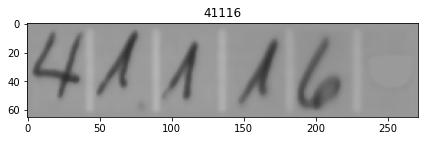

In [34]:
plt.title(label)
plt.imshow(image.permute(1, 2, 0));
plt.tight_layout()

### Visualize model predictions for one batch

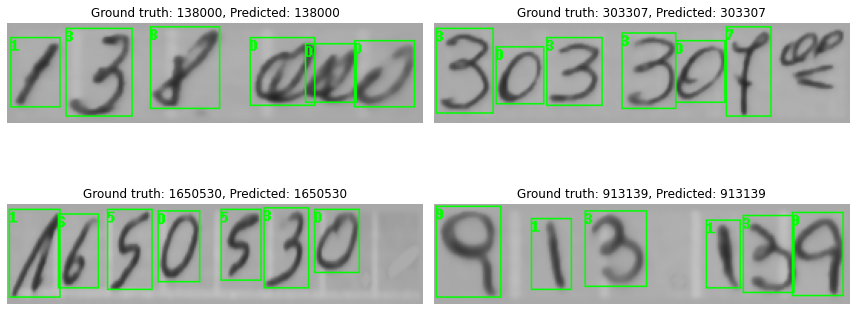

In [52]:
torch.cuda.empty_cache()
batch_size = 4
fig_size = 6
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
for images, labels in test_loader:
    images = images.to(device)
    model_pred = model(images)
    images_list = list(images.chunk(batch_size))
    
    # show detections
    fig, axs = plt.subplots(nrows=2, ncols=batch_size // 2, figsize=(fig_size*2, (fig_size // 2)*(batch_size // 2)))
    axs = axs.reshape(-1)
    for i, (single_image, real_label, detections) in enumerate(zip(images_list, labels, model_pred)):
        
        single_image = (single_image * 255).type(torch.ByteTensor)
        boxes = detections['boxes']
        
        if len(boxes) > 0:
            
            # get predicted number
            sorted_idxs = torch.argsort(boxes[:, 0], dim=0)    # sort by x coord
            sorted_boxes = boxes[sorted_idxs]
            sorted_labels = detections['labels'][sorted_idxs]
            sorted_scores = detections['scores'][sorted_idxs]
            pred_labels = [str(s) for s in list(sorted_labels.detach().cpu().numpy())]
            pred_number = "".join(pred_labels)
            # print(f"Ground truth: {real_label}, Predicted: {pred_number}")
            
            # plot image and detections
            colors = [(0, 255, 0)] * len(pred_labels)
            image_with_bboxes = torchvision.utils.draw_bounding_boxes(single_image.squeeze(0), sorted_boxes, pred_labels, colors=colors, font_size=12)
            
            axs[i].set_title(f"Ground truth: {real_label}, Predicted: {pred_number}")
            axs[i].imshow(image_with_bboxes.permute(1, 2, 0))
            axs[i].axis('off')

    plt.tight_layout()
    plt.savefig("retinanet_sample.svg")
    plt.show()
    break